In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import argparse
import cv2
from PIL import Image

# Model Definition

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
        name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

# Load in Data

In [3]:
num_images = 1260
train = []
test = []
for i in range(num_images):
    img = Image.open("reduced_frames/frame%d_reduced.jpg" % i)
    if np.random.rand() > 0.2:
        train.append(np.array(img))
    else:
        test.append(np.array(img))
        
trainX = np.asarray(train)
testX = np.asarray(test)
print(testX.shape)
print(trainX.shape)

(254, 168, 300)
(1006, 168, 300)


# Add Noise to Data

Actual Image:


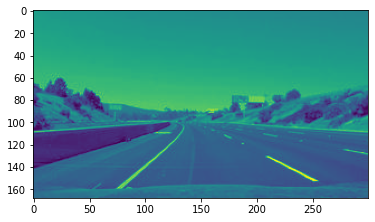

Image with Noise:


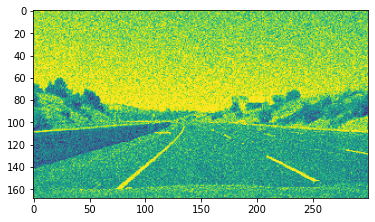

In [4]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX / 255.0
testX = testX / 255.0

trainNoise = np.random.normal(loc=0.3, scale=0.1, size=trainX.shape)
testNoise = np.random.normal(loc=0.3, scale=0.1, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

print("Actual Image:")
plt.imshow(testX[0].reshape((168,300)))
plt.show()
print("Image with Noise:")
plt.imshow(testXNoisy[0].reshape((168,300)))
plt.show()

# Load in Trained Model

In [5]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(300, 168, 1)
autoencoder.load_weights('autoencoder_weights')

Actual Image:


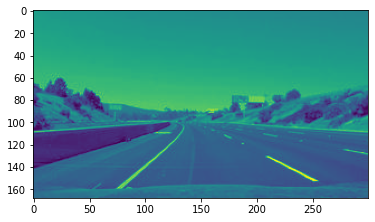

Image with Noise:


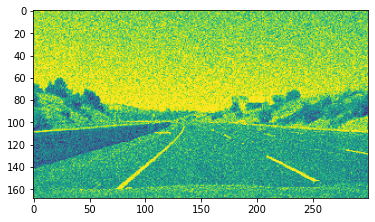

Reconstructed Image


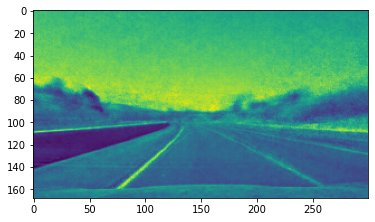

In [6]:
print("Actual Image:")
plt.imshow(testX[0].reshape((168,300)))
plt.show()
print("Image with Noise:")
plt.imshow(testXNoisy[0].reshape((168,300)))
plt.show()
recon = autoencoder(testXNoisy[0].reshape(1,168,300,1)).numpy()
print("Reconstructed Image")
plt.imshow(recon.reshape((168,300)))
plt.show()

In [7]:
def region(image):
    height, width = image.shape
    triangle = np.array([
                       [(0, height-20), (width//2, 100), (width, height-20)]
                       ])
    
    mask = np.zeros_like(image)
    
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

def get_lines(imgG):
    imgG = imgG.reshape((168,300))*255

    mask_light = cv2.inRange(imgG, 110,255)
    
    isolated = region(mask_light)

    lines = cv2.HoughLinesP(isolated,rho = 2,theta = 1*np.pi/180,threshold = 10,minLineLength = 10,maxLineGap = 10)

    for l in lines:
        l = l[0]
        cv2.line(imgG, (l[0], l[1]), (l[2], l[3]), 255, 2)
        
    return imgG

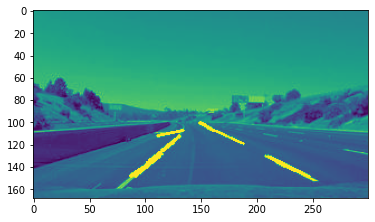

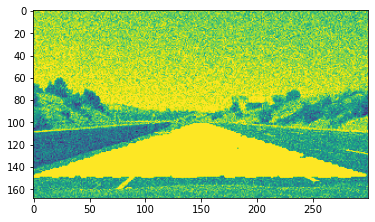

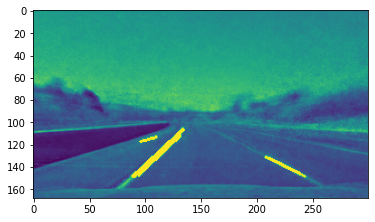

In [8]:
lines_true = get_lines(testX[0])
plt.imshow(lines_true)
plt.show()

lines_blurred = get_lines(testXNoisy[0])
plt.imshow(lines_blurred)
plt.show()

lines_recon = get_lines(autoencoder(testXNoisy[0].reshape(1,168,300,1)).numpy())
plt.imshow(lines_recon)
plt.show()

In [9]:
def get_MSE(img1, img2):
    im1Lines = get_lines(img1)
    im2Lines = get_lines(img2)

    err = np.sum((im1Lines.astype("float") - im2Lines.astype("float")) ** 2)
    err /= float(im1Lines.shape[0] * im1Lines.shape[1])

    return err

print(get_MSE(testX[0], testXNoisy[0]))
print(get_MSE(testX[0], autoencoder(testXNoisy[0].reshape(1,168,300,1)).numpy()))

9609.972563709585
443.0655001648906
